# COVID-19 analysis

- <https://github.com/Kamaropoulos/covid19py>

Note that the JHU data source is not providing recovery data at this time ([reference](https://github.com/ExpDev07/coronavirus-tracker-api/blob/master/README.md#recovered-cases-showing-0)).

Another source of data might be the following: <https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data>

## data sources (acquired reliably from CERN)

```Bash
mkdir COVID19
cd COVID19
virtualenv -p python3.6 COVID19
source COVID19/bin/activate
pip3.6 install pip --upgrade
pip3.6 install jupyter matplotlib numpy pandas requests seaborn
pip3.6 install COVID19Py
python3.6

import COVID19Py
import numpy as np
import pandas as pd

import json
import pickle
from uuid import uuid4

def uuid4_short():
    return str(uuid4()).split('-')[0]

def new_filename(ext='.pkl', verbose=True):
    filename = uuid4_short()+ext
    if verbose:
        print(filename)
    return filename

covid19 = COVID19Py.COVID19()
data = covid19.getAll(timelines=True)

with open(new_filename(), 'wb') as f:
    pickle.dump(data, f)
```

In [1]:
import json
import pickle
from uuid import uuid4
import warnings

import COVID19Py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['axes.labelcolor'] = (1, 1, 1, 0)
pd.set_option("display.max_rows"   , 1000)
pd.set_option("display.max_columns", 1000)
sns.set_palette('husl')
sns.set(style='ticks')
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = [13, 6]
sns.set()

In [3]:
def uuid4_short():
    return str(uuid4()).split('-')[0]
def new_filename(ext='.pkl', verbose=True):
    filename = uuid4_short()+ext
    if verbose: print(filename)
    return filename

In [4]:
%%time
if 0:
    covid19 = COVID19Py.COVID19(data_source='jhu') # https://github.com/CSSEGISandData/COVID-19
    with open(new_filename(), 'wb') as f:
        pickle.dump(data, f)
    data = covid19.getAll(timelines=True)
    with open(new_filename(), 'wb') as f:
        pickle.dump(data, f)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 3.34 µs


In [5]:
if 1:
    #with open('12338731.pkl', 'rb') as f:
    #    covid19 = pickle.load(f)
    with open('d5fb657f.pkl', 'rb') as f:
        data = pickle.load(f)
    # records:
    # 2020-04-12T0527z data: d5fb657f.pkl
    # 2020-04-11T2322Z data: 2ed0a4f8.pkl
    # 2020-04-10T1904Z covid19: 12338731.pkl, data: 7a48429f.pkl
    # 2020-04-09T0544Z covid19: 7f150185.pkl, data: 5f3d2ff9.pkl
    # 2020-04-08T0616Z covid19: 8f0ec81a.pkl, data: 741cd4d4.pkl
    # 2020-04-07       covid19: f94e6997.pkl, data: 120141ce.pkl

#latest = covid19.getLatest()
#locations = covid19.getLocations(timelines=True)

df = pd.DataFrame(data['locations'])
df.head()
#df

,id,country,country_code,country_population,province,last_updated,coordinates,latest,timelines
0,0,Afghanistan,AF,29121286.0,,2020-04-12T05:01:20.820438Z,"{'latitude': '33.0', 'longitude': '65.0'}","{'confirmed': 555, 'deaths': 18, 'recovered': 0}","{'confirmed': {'latest': 555, 'timeline': {'20..."
1,1,Albania,AL,2986952.0,,2020-04-12T05:01:20.824518Z,"{'latitude': '41.1533', 'longitude': '20.1683'}","{'confirmed': 433, 'deaths': 23, 'recovered': 0}","{'confirmed': {'latest': 433, 'timeline': {'20..."
2,2,Algeria,DZ,34586184.0,,2020-04-12T05:01:20.827933Z,"{'latitude': '28.0339', 'longitude': '1.6596'}","{'confirmed': 1825, 'deaths': 275, 'recovered'...","{'confirmed': {'latest': 1825, 'timeline': {'2..."
3,3,Andorra,AD,84000.0,,2020-04-12T05:01:20.831315Z,"{'latitude': '42.5063', 'longitude': '1.5218'}","{'confirmed': 601, 'deaths': 26, 'recovered': 0}","{'confirmed': {'latest': 601, 'timeline': {'20..."
4,4,Angola,AO,13068161.0,,2020-04-12T05:01:20.834642Z,"{'latitude': '-11.2027', 'longitude': '17.8739'}","{'confirmed': 19, 'deaths': 2, 'recovered': 0}","{'confirmed': {'latest': 19, 'timeline': {'202..."


In [6]:
locations = {}

In [7]:
def process(location):
    location = location['timelines'].values[0]

    confirmed = pd.DataFrame(list(location['confirmed']['timeline'].items()), columns=['datetime', 'confirmed'])
    deaths    = pd.DataFrame(list(location['deaths']['timeline'].items()),    columns=['datetime', 'deaths'])
    recovered = pd.DataFrame(list(location['recovered']['timeline'].items()), columns=['datetime', 'recovered'])

    confirmed.index = pd.to_datetime(confirmed['datetime']); del confirmed['datetime']
    deaths.index    = pd.to_datetime(deaths['datetime'])   ; del deaths['datetime']
    recovered.index = pd.to_datetime(recovered['datetime']); del recovered['datetime']

    # merge
    location = confirmed
    location['deaths']       = deaths['deaths']
    location['recovered']    = recovered['recovered']

    # visual estimate of changes (with linear interpolation)
    half_mean_of_confirmed_cases = location['confirmed'].mean()/2
    half_mean_of_deaths_cases    = location['deaths'].mean()/2
    location['confirmed_percentage_change']                                     = location['confirmed'].pct_change().replace(0, np.nan).interpolate(method='nearest')
    location['confirmed_percentage_change']                                     = 100*location['confirmed_percentage_change']
    location['confirmed_percentage_change_by_half_mean_confirmed_cases_factor'] = half_mean_of_confirmed_cases*location['confirmed_percentage_change']
    location['deaths_percentage_change']                                        = location['deaths'].pct_change().replace(0, np.nan).interpolate(method='nearest')
    location['deaths_percentage_change']                                        = 100*location['deaths_percentage_change']
    location['deaths_percentage_change_by_half_mean_deaths_cases_factor']       = half_mean_of_confirmed_cases*location['deaths_percentage_change']    
    
    # reindex to first confirmed case
    location = location.query('confirmed > 0').reset_index(); del location['datetime']

    display(location.tail())

    #plots
    df_plot = location.drop([
        'confirmed_percentage_change',
        'confirmed_percentage_change_by_half_mean_confirmed_cases_factor',
        'deaths_percentage_change',
        'deaths_percentage_change_by_half_mean_deaths_cases_factor'], axis=1)
    df_plot.plot(title=location_name+' confirmed cases and deaths (linear scale)')                   ; plt.xlabel('days since first confirmed case'); plt.ylabel('cases');
    df_plot.plot(title=location_name+' confirmed cases and deaths (log scale)', logy=True)           ; plt.xlabel('days since first confirmed case'); plt.ylabel('cases');

    df_plot = location[['confirmed_percentage_change', 'deaths_percentage_change']]
    df_plot.plot(title=location_name+' percentage change in cases and deaths (linear scale)')        ; plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');
    df_plot.plot(title=location_name+' percentage change in cases and deaths (log scale)', logy=True); plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');

    return location

# South Korea

,confirmed,deaths,recovered,confirmed_percentage_change,confirmed_percentage_change_by_half_mean_confirmed_cases_factor,deaths_percentage_change,deaths_percentage_change_by_half_mean_deaths_cases_factor
76,10331,192,NaN,0.457021,1043.112878,3.225806,7362.644365
77,10384,200,NaN,0.513019,1170.924856,4.166667,9510.082305
78,10423,204,NaN,0.375578,857.226217,2.000000,4564.839506
79,10450,208,NaN,0.259043,591.243724,1.960784,4475.332849
80,10480,211,NaN,0.287081,655.240121,1.442308,3291.951567


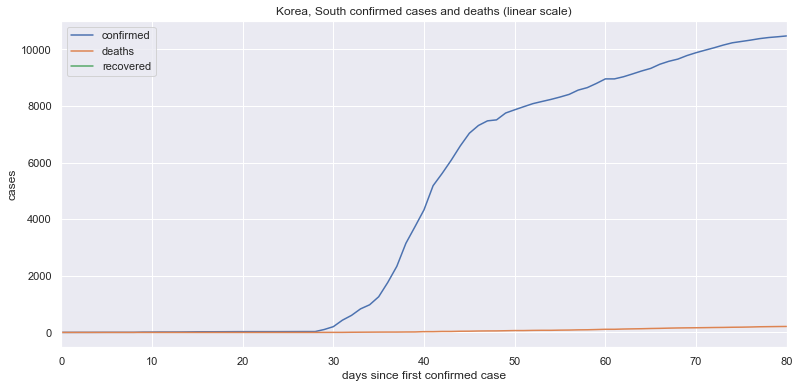

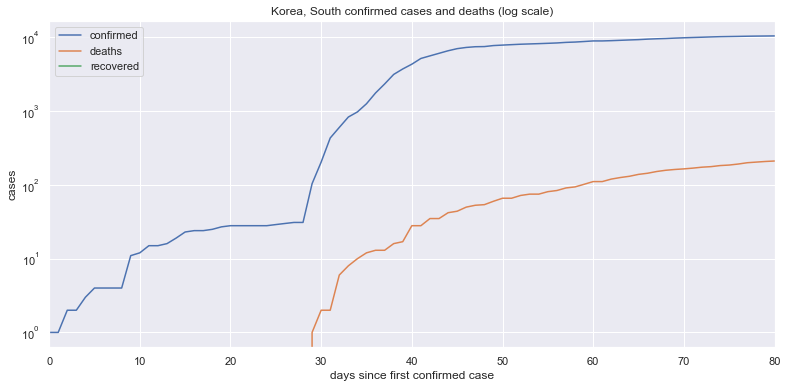

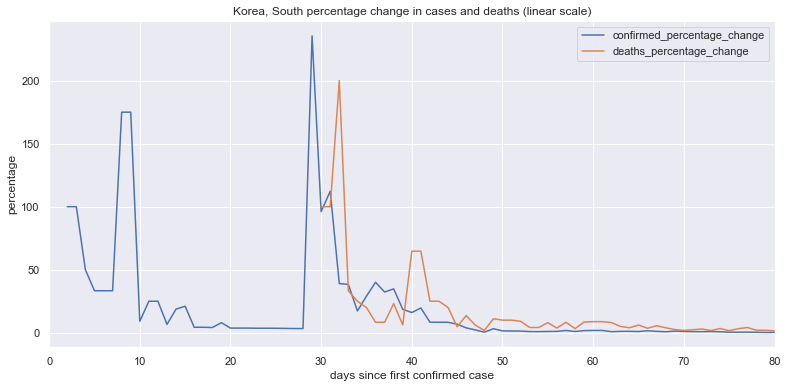

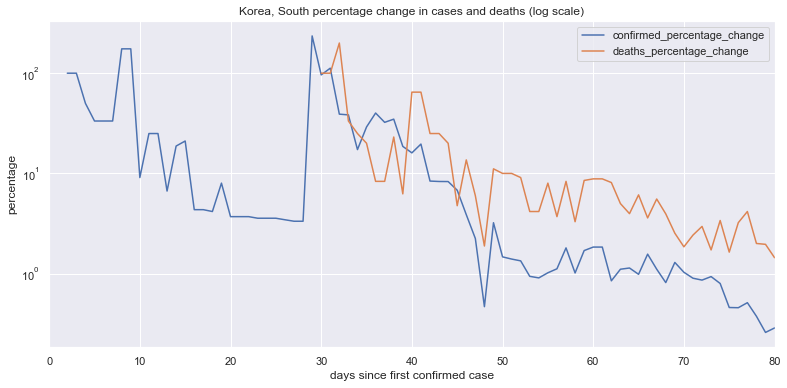

In [8]:
location_name = 'Korea, South'
location = df.query('country == @location_name')
location = process(location)
locations[location_name] = location

# Sweden

,confirmed,deaths,recovered,confirmed_percentage_change,confirmed_percentage_change_by_half_mean_confirmed_cases_factor,deaths_percentage_change,deaths_percentage_change_by_half_mean_deaths_cases_factor
67,7693,591,NaN,6.758257,5262.053998,23.899371,18608.315863
68,8419,687,NaN,9.437151,7347.870358,16.243655,12647.490130
69,9141,793,NaN,8.575840,6677.244592,15.429403,12013.504771
70,9685,870,NaN,5.951209,4633.677327,9.709962,7560.284433
71,10151,887,NaN,4.811564,3746.337406,1.954023,1521.424010


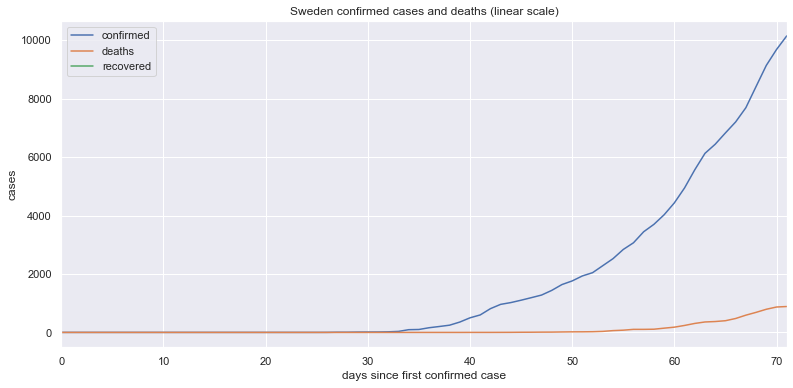

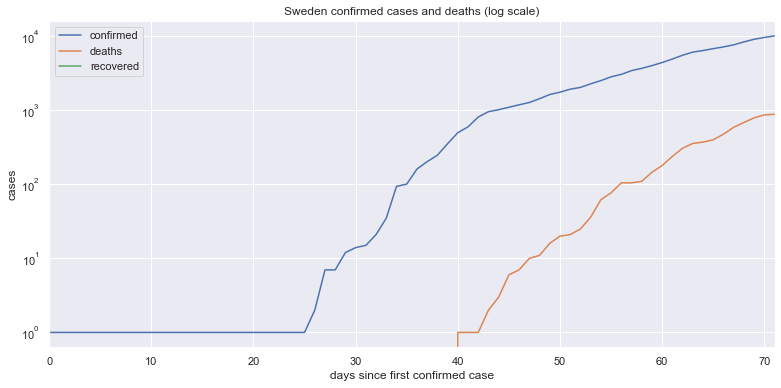

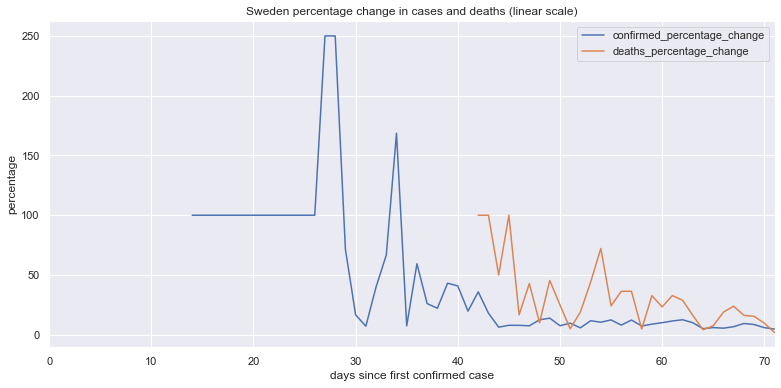

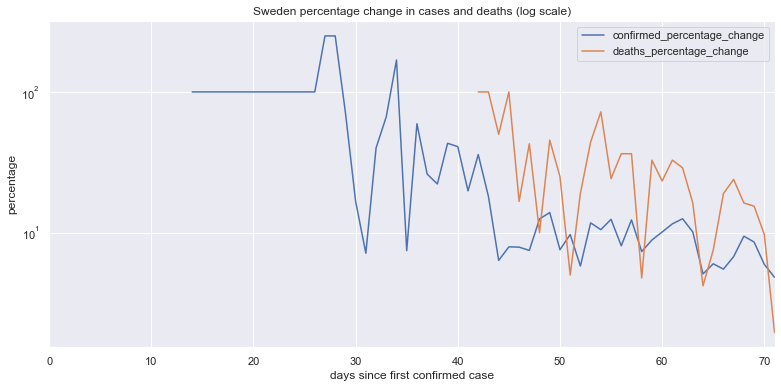

In [9]:
location_name = 'Sweden'
location = df.query('country == @location_name')
location = process(location)
locations[location_name] = location

# Ireland

,confirmed,deaths,recovered,confirmed_percentage_change,confirmed_percentage_change_by_half_mean_confirmed_cases_factor,deaths_percentage_change,deaths_percentage_change_by_half_mean_deaths_cases_factor
38,5709,210,NaN,6.431767,3383.189024,20.689655,10883.014049
39,6074,235,NaN,6.393414,3363.014647,11.904762,6262.051734
40,6574,263,NaN,8.231808,4330.032480,11.914894,6267.381140
41,8089,287,NaN,23.045330,12122.128137,9.125475,4800.112660
42,8928,320,NaN,10.372110,5455.858054,11.498258,6048.225577


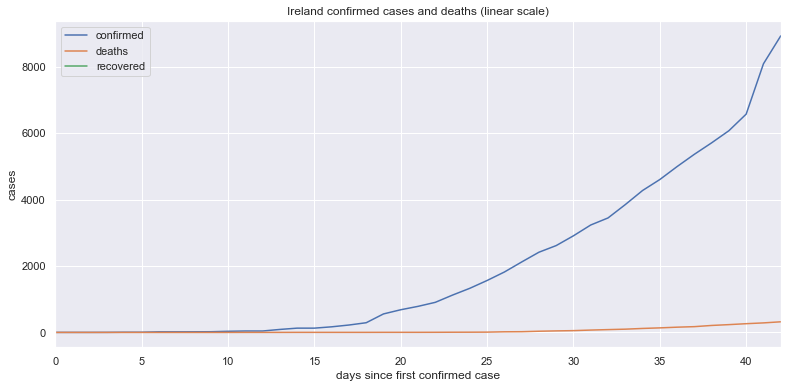

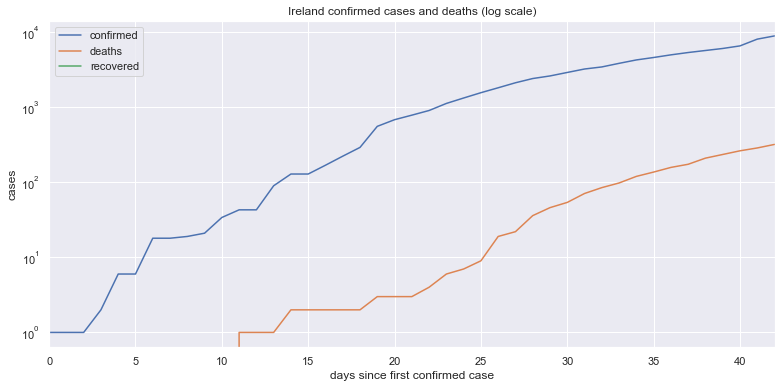

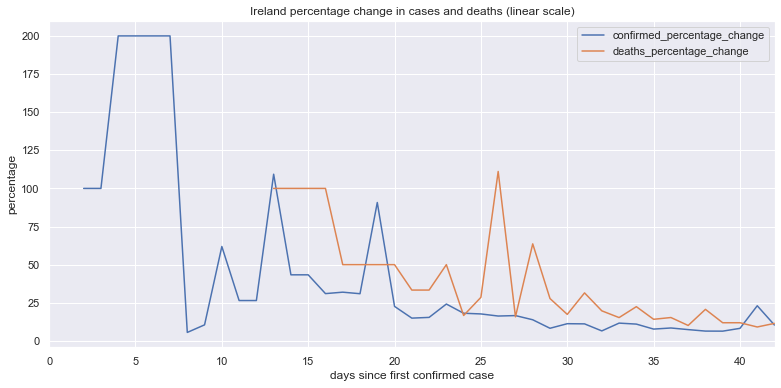

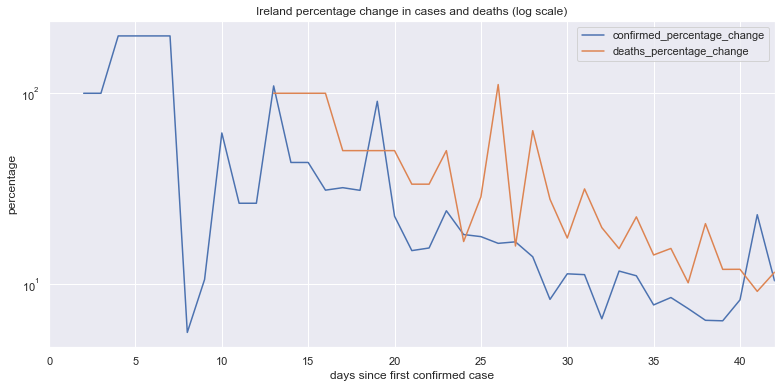

In [10]:
location_name = 'Ireland'
location = df.query('country == @location_name')
location = process(location)
locations[location_name] = location

# United Kingdom (approximate)

,confirmed,deaths,recovered,confirmed_percentage_change,confirmed_percentage_change_by_half_mean_confirmed_cases_factor,deaths_percentage_change,deaths_percentage_change_by_half_mean_deaths_cases_factor
67,55242,6159,NaN,7.041544,32175.291873,14.628699,66843.673098
68,60733,7097,NaN,9.939901,45418.904128,15.229745,69590.063923
69,65077,7978,NaN,7.152619,32682.832141,12.413696,56722.544476
70,73758,8958,NaN,13.339582,60953.245272,12.283780,56128.914701
71,78991,9875,NaN,7.094824,32418.745412,10.236660,46774.901185


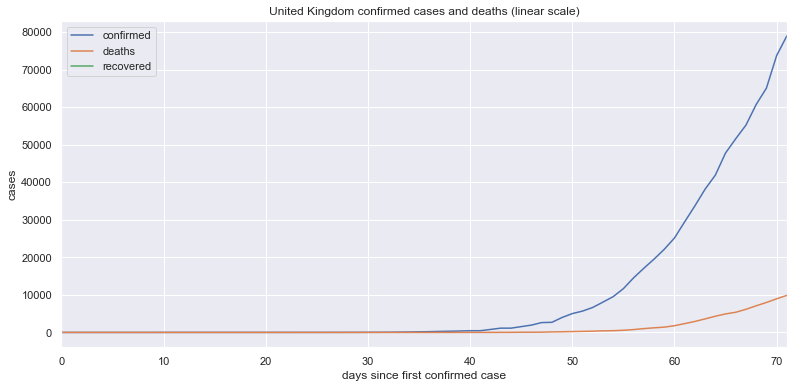

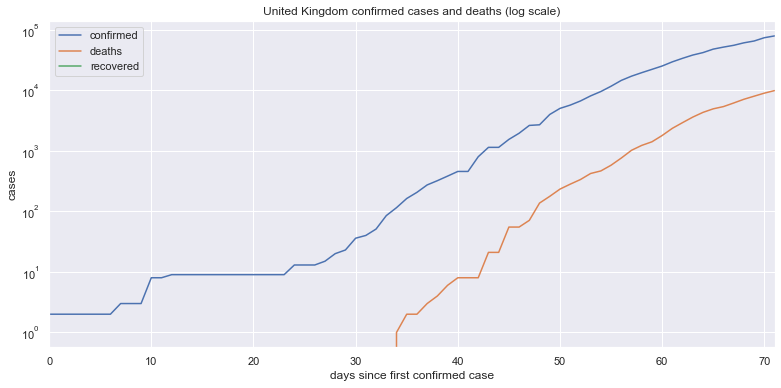

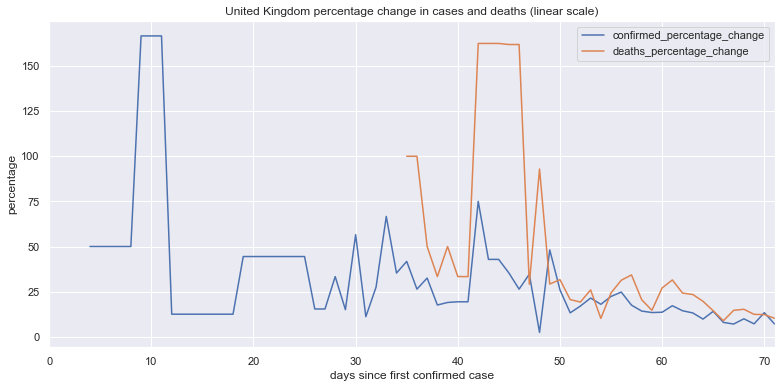

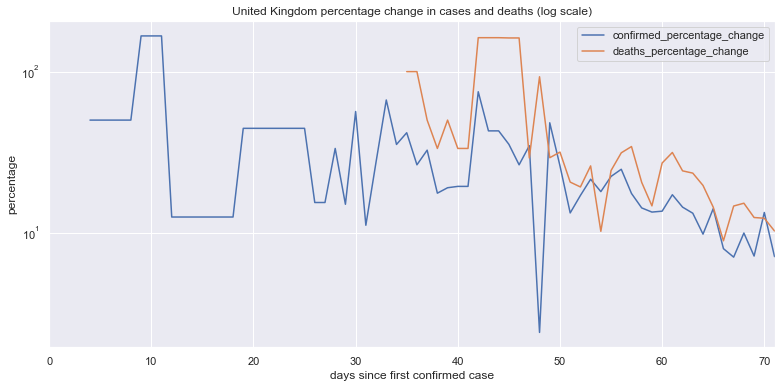

In [11]:
location_name = 'United Kingdom'
#location = df.query('country == @location_name')
location = df.query('country in ["United Kingdom"] and province == ""')
location = process(location)
locations[location_name] = location

# Germany

,confirmed,deaths,recovered,confirmed_percentage_change,confirmed_percentage_change_by_half_mean_confirmed_cases_factor,deaths_percentage_change,deaths_percentage_change_by_half_mean_deaths_cases_factor
71,107663,2016,NaN,4.149012,44266.145432,11.381215,121427.101153
72,113296,2349,NaN,5.232067,55821.339765,16.517857,176230.343364
73,118181,2607,NaN,4.311714,46002.027438,10.983397,117182.746007
74,122171,2767,NaN,3.376177,36020.705685,6.137323,65479.587246
75,124908,2736,NaN,2.240303,23901.967436,-1.120347,-11953.071473


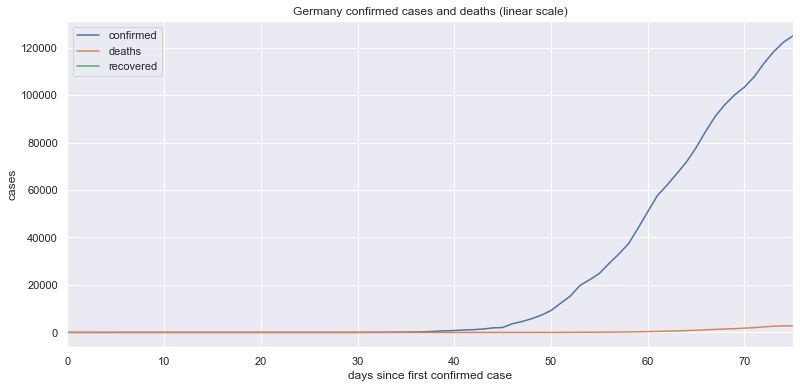

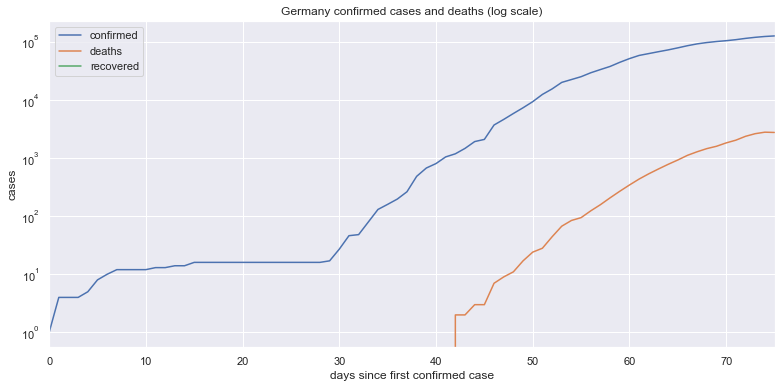

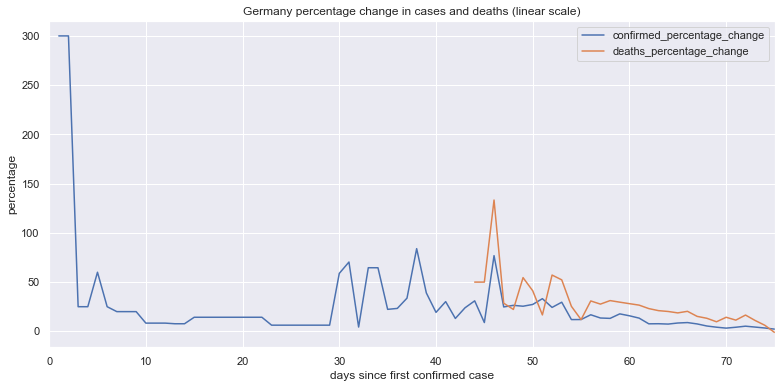

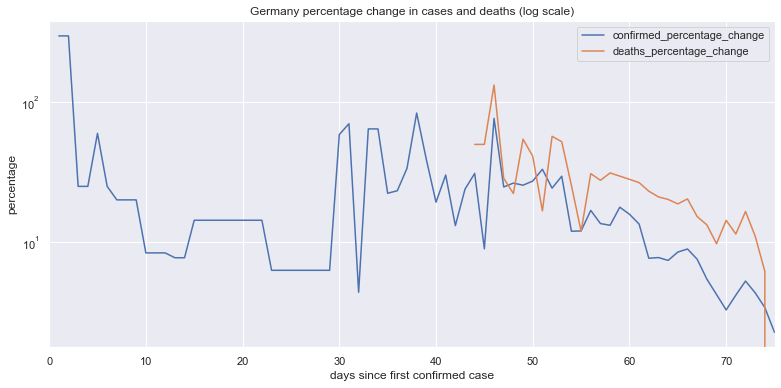

In [12]:
location_name = 'Germany'
location = df.query('country == @location_name')
location = process(location)
locations[location_name] = location

# Italy

,confirmed,deaths,recovered,confirmed_percentage_change,confirmed_percentage_change_by_half_mean_confirmed_cases_factor,deaths_percentage_change,deaths_percentage_change_by_half_mean_deaths_cases_factor
67,135586,17127,NaN,2.292772,37665.722948,3.655511,60052.839327
68,139422,17669,NaN,2.829201,46478.195680,3.164594,51988.046525
69,143626,18279,NaN,3.015306,49535.540842,3.452374,56715.710154
70,147577,18849,NaN,2.750895,45191.782786,3.118333,51228.062764
71,152271,19468,NaN,3.180712,52252.842161,3.283994,53949.552257


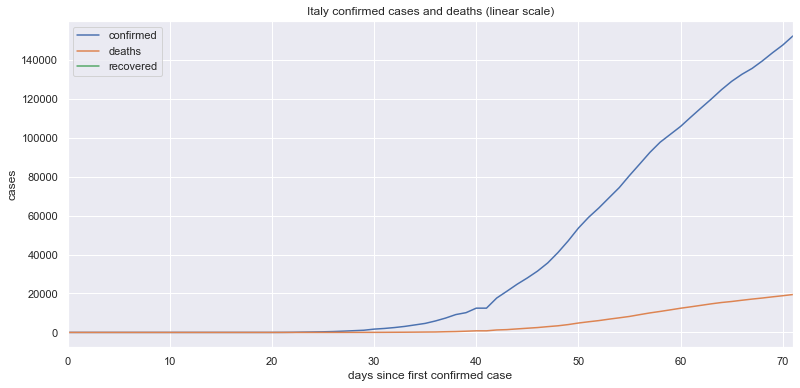

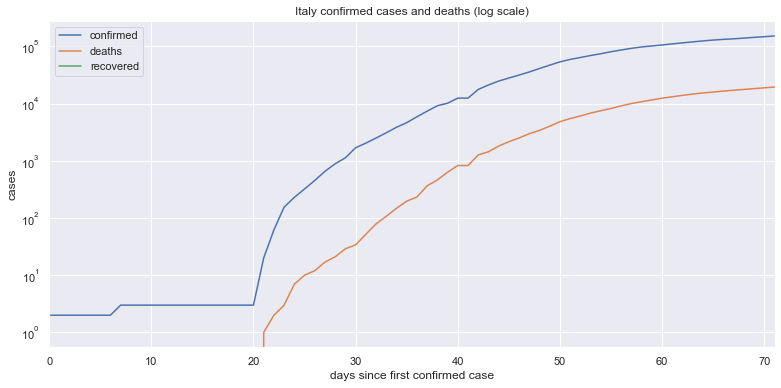

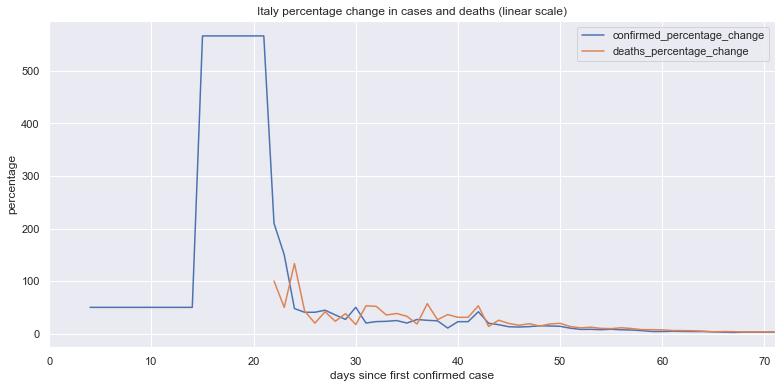

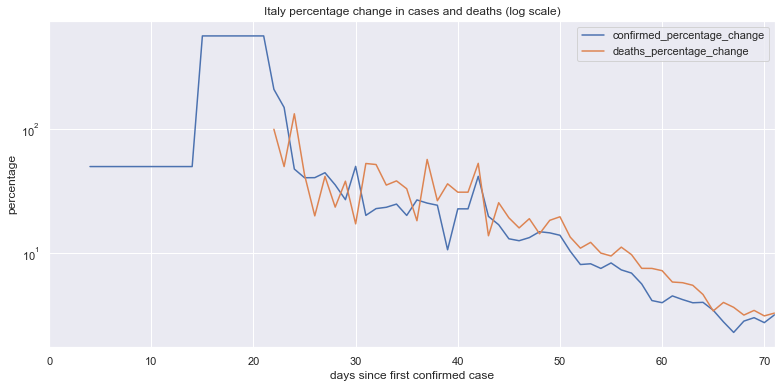

In [13]:
location_name = 'Italy'
location = df.query('country == @location_name')
location = process(location)
locations[location_name] = location

# United States of America

,confirmed,deaths,recovered,confirmed_percentage_change,confirmed_percentage_change_by_half_mean_confirmed_cases_factor,deaths_percentage_change,deaths_percentage_change_by_half_mean_deaths_cases_factor
76,396223,12722,NaN,8.060720,255868.696544,17.982009,570796.797714
77,429052,14695,NaN,8.285486,263003.359561,15.508568,492283.203540
78,461437,16478,NaN,7.548036,239594.748444,12.133379,385145.720725
79,496535,18586,NaN,7.606239,241442.254958,12.792815,406077.972575
80,526396,20463,NaN,6.013876,190896.429256,10.098999,320569.104417


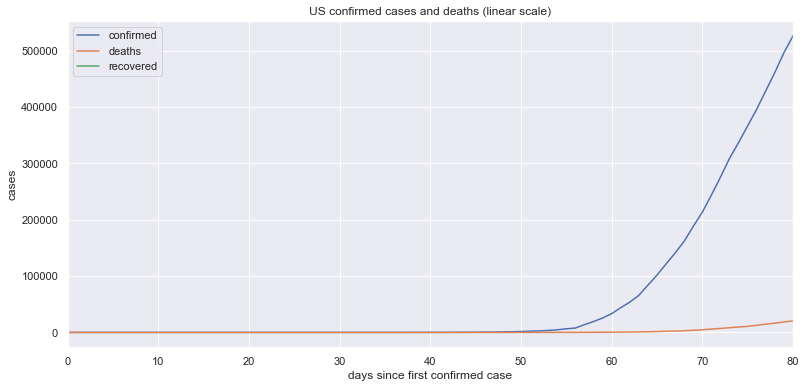

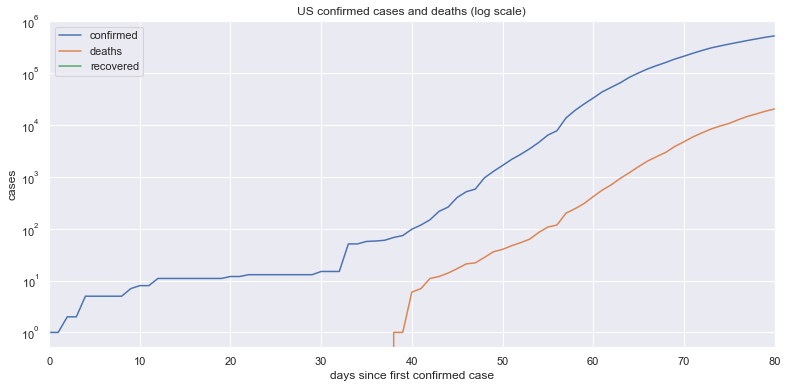

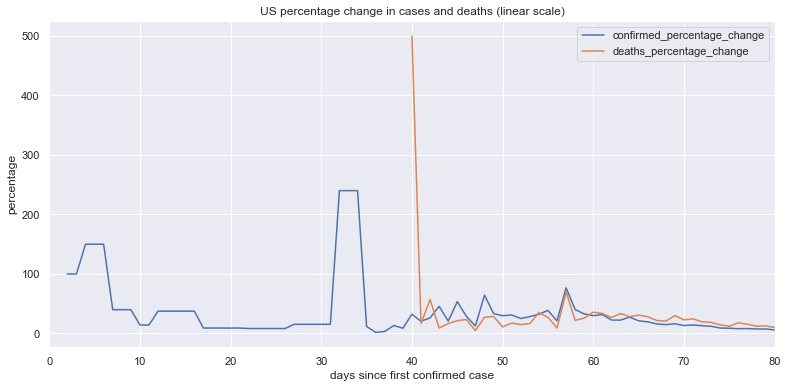

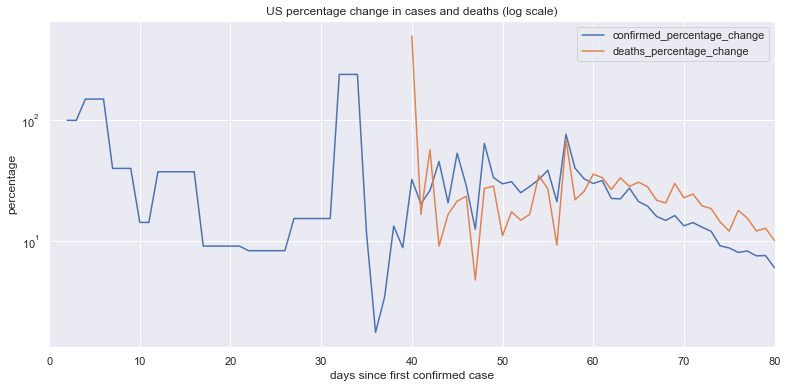

In [14]:
location_name = 'US'
location = df.query('country == @location_name')
location = process(location)
locations[location_name] = location

---

In [15]:
South_Korea              = locations['Korea, South']
Sweden                   = locations['Sweden']
Ireland                  = locations['Ireland']
United_Kingdom           = locations['United Kingdom']
Germany                  = locations['Germany']
Italy                    = locations['Italy']
United_States_of_America = locations['US']

locations_list           = [South_Korea,
                            Sweden,
                            Ireland,
                            United_Kingdom,
                            Germany,
                            Italy,
                            United_States_of_America]

In [16]:
#South_Korea

In [17]:
_df = pd.merge(South_Korea.add_suffix('_South_Korea'), Sweden.add_suffix('_Sweden'), how='outer', left_index=True, right_index=True)
_df = pd.merge(_df, Ireland.add_suffix('_Ireland'), how='outer', left_index=True, right_index=True)
_df = pd.merge(_df, United_Kingdom.add_suffix('_United_Kingdom'), how='outer', left_index=True, right_index=True)
_df = pd.merge(_df, Germany.add_suffix('_Germany'), how='outer', left_index=True, right_index=True)
_df = pd.merge(_df, Italy.add_suffix('_Italy'), how='outer', left_index=True, right_index=True)
_df = pd.merge(_df, United_States_of_America.add_suffix('_United_States_of_America'), how='outer', left_index=True, right_index=True)
_df.tail()

,confirmed_South_Korea,deaths_South_Korea,recovered_South_Korea,confirmed_percentage_change_South_Korea,confirmed_percentage_change_by_half_mean_confirmed_cases_factor_South_Korea,deaths_percentage_change_South_Korea,deaths_percentage_change_by_half_mean_deaths_cases_factor_South_Korea,confirmed_Sweden,deaths_Sweden,recovered_Sweden,confirmed_percentage_change_Sweden,confirmed_percentage_change_by_half_mean_confirmed_cases_factor_Sweden,deaths_percentage_change_Sweden,deaths_percentage_change_by_half_mean_deaths_cases_factor_Sweden,confirmed_Ireland,deaths_Ireland,recovered_Ireland,confirmed_percentage_change_Ireland,confirmed_percentage_change_by_half_mean_confirmed_cases_factor_Ireland,deaths_percentage_change_Ireland,deaths_percentage_change_by_half_mean_deaths_cases_factor_Ireland,confirmed_United_Kingdom,deaths_United_Kingdom,recovered_United_Kingdom,confirmed_percentage_change_United_Kingdom,confirmed_percentage_change_by_half_mean_confirmed_cases_factor_United_Kingdom,deaths_percentage_change_United_Kingdom,deaths_percentage_change_by_half_mean_deaths_cases_factor_United_Kingdom,confirmed_Germany,deaths_Germany,recovered_Germany,confirmed_percentage_change_Germany,confirmed_percentage_change_by_half_mean_confirmed_cases_factor_Germany,deaths_percentage_change_Germany,deaths_percentage_change_by_half_mean_deaths_cases_factor_Germany,confirmed_Italy,deaths_Italy,recovered_Italy,confirmed_percentage_change_Italy,confirmed_percentage_change_by_half_mean_confirmed_cases_factor_Italy,deaths_percentage_change_Italy,deaths_percentage_change_by_half_mean_deaths_cases_factor_Italy,confirmed_United_States_of_America,deaths_United_States_of_America,recovered_United_States_of_America,confirmed_percentage_change_United_States_of_America,confirmed_percentage_change_by_half_mean_confirmed_cases_factor_United_States_of_America,deaths_percentage_change_United_States_of_America,deaths_percentage_change_by_half_mean_deaths_cases_factor_United_States_of_America
76,10331,192,NaN,0.457021,1043.112878,3.225806,7362.644365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,396223,12722,NaN,8.060720,255868.696544,17.982009,570796.797714
77,10384,200,NaN,0.513019,1170.924856,4.166667,9510.082305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,429052,14695,NaN,8.285486,263003.359561,15.508568,492283.203540
78,10423,204,NaN,0.375578,857.226217,2.000000,4564.839506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,461437,16478,NaN,7.548036,239594.748444,12.133379,385145.720725
79,10450,208,NaN,0.259043,591.243724,1.960784,4475.332849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,496535,18586,NaN,7.606239,241442.254958,12.792815,406077.972575
80,10480,211,NaN,0.287081,655.240121,1.442308,3291.951567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,526396,20463,NaN,6.013876,190896.429256,10.098999,320569.104417


# comparisons: confirmed cases

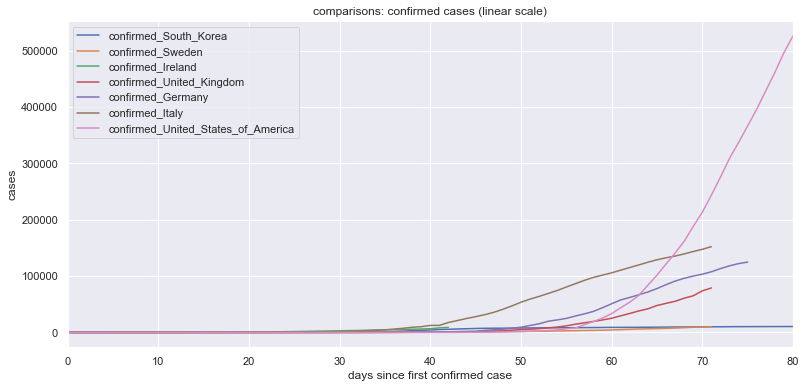

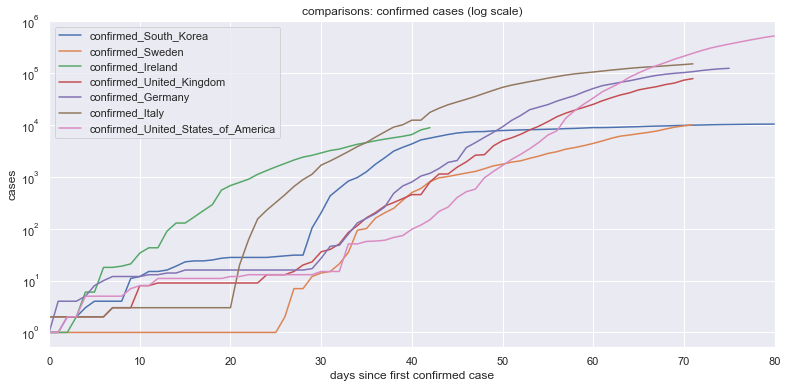

In [18]:
__df = _df[[
    'confirmed_South_Korea',
    'confirmed_Sweden',
    'confirmed_Ireland',
    'confirmed_United_Kingdom',
    'confirmed_Germany',
    'confirmed_Italy',
    'confirmed_United_States_of_America']]

title = 'comparisons: confirmed cases'
__df.plot(title=title+' '+'(linear scale)')        ; plt.xlabel('days since first confirmed case'); plt.ylabel('cases');
__df.plot(title=title+' '+'(log scale)', logy=True); plt.xlabel('days since first confirmed case'); plt.ylabel('cases');

# comparisons: deaths

,deaths_South_Korea,deaths_Sweden,deaths_Ireland,deaths_United_Kingdom,deaths_Germany,deaths_Italy,deaths_United_States_of_America
76,192,NaN,NaN,NaN,NaN,NaN,12722
77,200,NaN,NaN,NaN,NaN,NaN,14695
78,204,NaN,NaN,NaN,NaN,NaN,16478
79,208,NaN,NaN,NaN,NaN,NaN,18586
80,211,NaN,NaN,NaN,NaN,NaN,20463


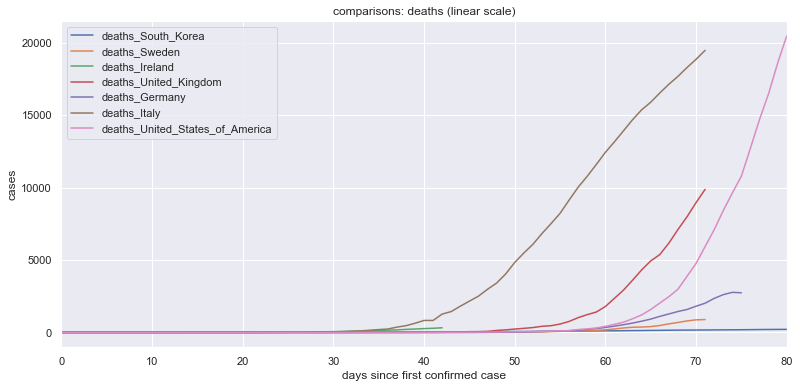

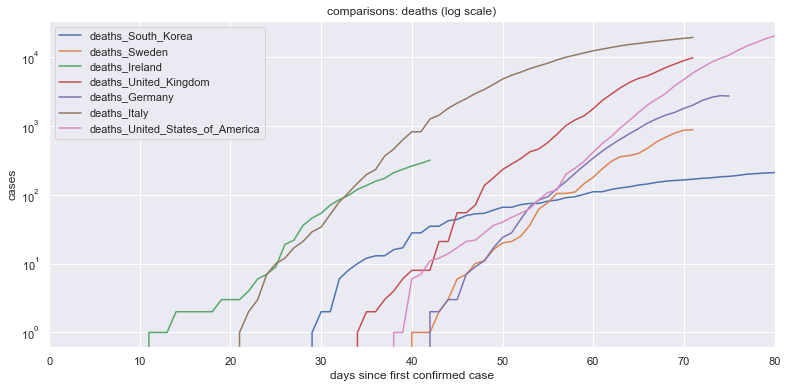

In [19]:
__df = _df[[
    'deaths_South_Korea',
    'deaths_Sweden',
    'deaths_Ireland',
    'deaths_United_Kingdom',
    'deaths_Germany',
    'deaths_Italy',
    'deaths_United_States_of_America']]
display(__df.tail())

title = 'comparisons: deaths'
__df.plot(title=title+' '+'(linear scale)')        ; plt.xlabel('days since first confirmed case'); plt.ylabel('cases');
__df.plot(title=title+' '+'(log scale)', logy=True); plt.xlabel('days since first confirmed case'); plt.ylabel('cases');

,deaths_Sweden,deaths_Ireland,deaths_United_Kingdom,deaths_Germany,deaths_Italy
76,NaN,NaN,NaN,NaN,NaN
77,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN
80,NaN,NaN,NaN,NaN,NaN


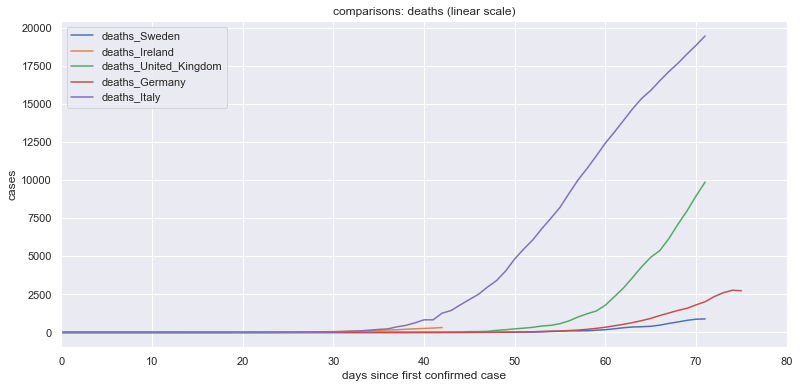

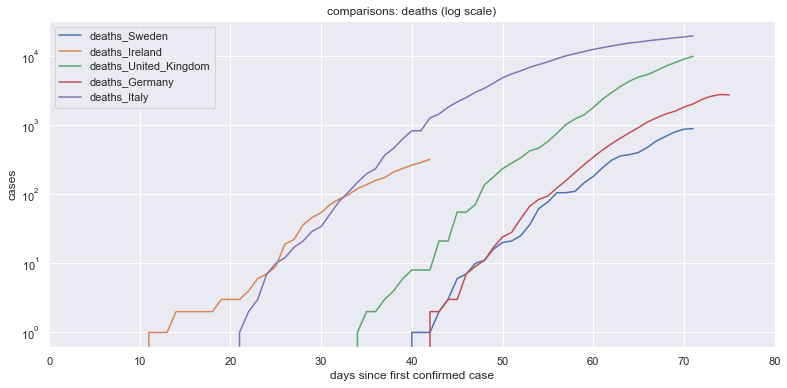

In [20]:
# some EU countries
__df = _df[[
    'deaths_Sweden',
    'deaths_Ireland',
    'deaths_United_Kingdom',
    'deaths_Germany',
    'deaths_Italy']]
display(__df.tail())

title = 'comparisons: deaths'
__df.plot(title=title+' '+'(linear scale)')        ; plt.xlabel('days since first confirmed case'); plt.ylabel('cases');
__df.plot(title=title+' '+'(log scale)', logy=True); plt.xlabel('days since first confirmed case'); plt.ylabel('cases');

# comparisons: changes in confirmed cases

,confirmed_percentage_change_South_Korea,confirmed_percentage_change_Sweden,confirmed_percentage_change_Ireland,confirmed_percentage_change_United_Kingdom,confirmed_percentage_change_Germany,confirmed_percentage_change_Italy,confirmed_percentage_change_United_States_of_America
76,0.457021,NaN,NaN,NaN,NaN,NaN,8.060720
77,0.513019,NaN,NaN,NaN,NaN,NaN,8.285486
78,0.375578,NaN,NaN,NaN,NaN,NaN,7.548036
79,0.259043,NaN,NaN,NaN,NaN,NaN,7.606239
80,0.287081,NaN,NaN,NaN,NaN,NaN,6.013876


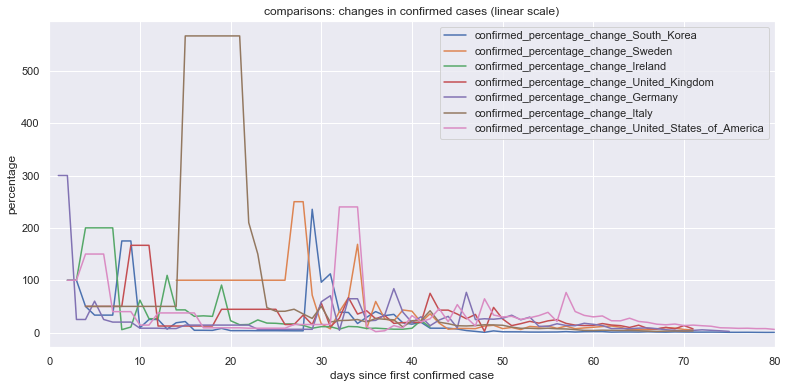

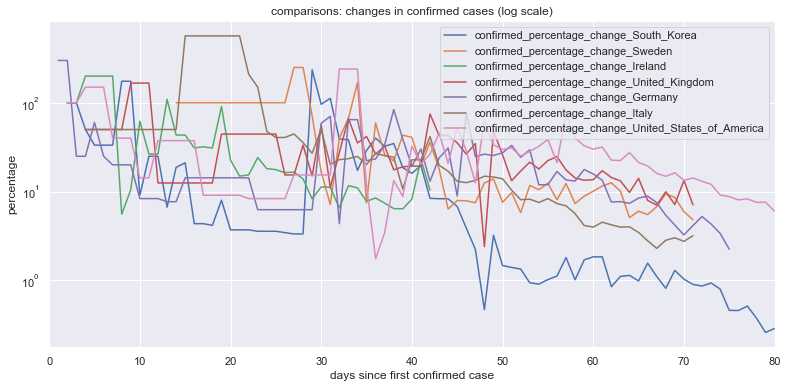

In [21]:
__df = _df[[
    'confirmed_percentage_change_South_Korea',
    'confirmed_percentage_change_Sweden',
    'confirmed_percentage_change_Ireland',
    'confirmed_percentage_change_United_Kingdom',
    'confirmed_percentage_change_Germany',
    'confirmed_percentage_change_Italy',
    'confirmed_percentage_change_United_States_of_America']]
display(__df.tail())

title = 'comparisons: changes in confirmed cases'
__df.plot(title=title+' '+'(linear scale)')        ; plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');
__df.plot(title=title+' '+'(log scale)', logy=True); plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');

,deaths_percentage_change_South_Korea,deaths_percentage_change_Sweden,deaths_percentage_change_Ireland,deaths_percentage_change_United_Kingdom,deaths_percentage_change_Germany,deaths_percentage_change_Italy,deaths_percentage_change_United_States_of_America
76,3.225806,NaN,NaN,NaN,NaN,NaN,17.982009
77,4.166667,NaN,NaN,NaN,NaN,NaN,15.508568
78,2.000000,NaN,NaN,NaN,NaN,NaN,12.133379
79,1.960784,NaN,NaN,NaN,NaN,NaN,12.792815
80,1.442308,NaN,NaN,NaN,NaN,NaN,10.098999


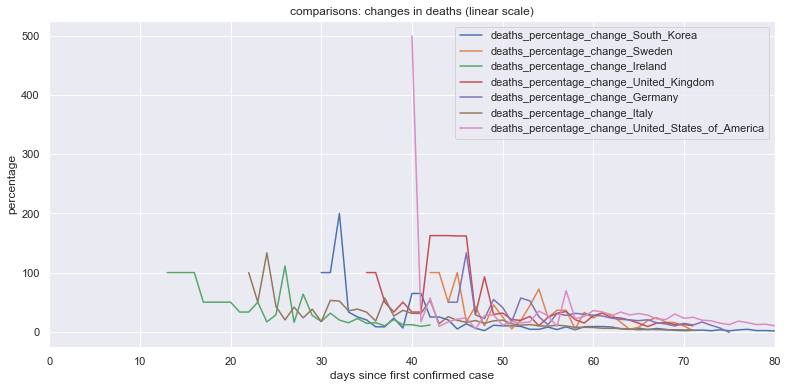

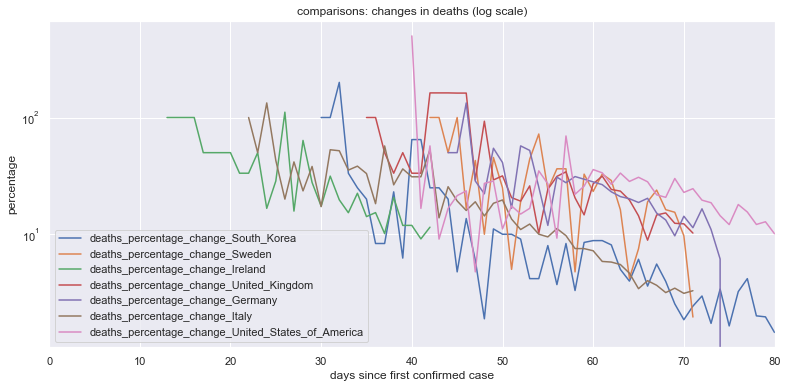

In [22]:
___df = _df[[
    'deaths_percentage_change_South_Korea',
    'deaths_percentage_change_Sweden',
    'deaths_percentage_change_Ireland',
    'deaths_percentage_change_United_Kingdom',
    'deaths_percentage_change_Germany',
    'deaths_percentage_change_Italy',
    'deaths_percentage_change_United_States_of_America']]
display(___df.tail())

title = 'comparisons: changes in deaths'
___df.plot(title=title+' '+'(linear scale)')        ; plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');
___df.plot(title=title+' '+'(log scale)', logy=True); plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');

,deaths_percentage_change_Sweden,deaths_percentage_change_Ireland,deaths_percentage_change_United_Kingdom,deaths_percentage_change_Germany,deaths_percentage_change_Italy
76,NaN,NaN,NaN,NaN,NaN
77,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN
80,NaN,NaN,NaN,NaN,NaN


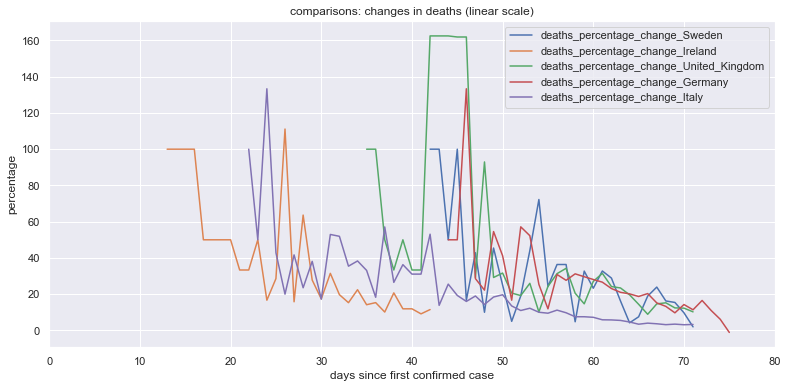

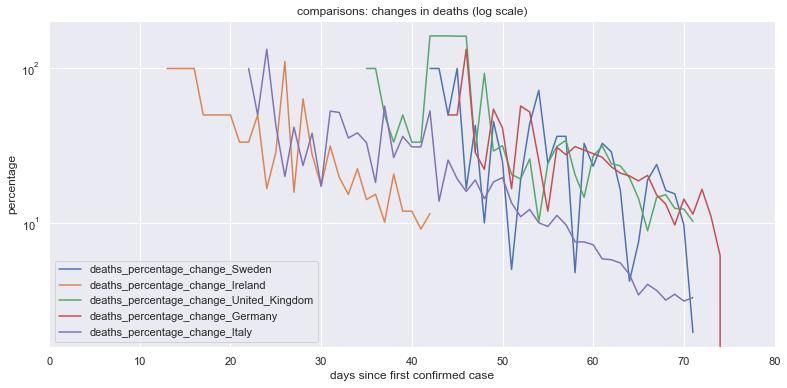

In [23]:
# some EU countries
___df = _df[[
    'deaths_percentage_change_Sweden',
    'deaths_percentage_change_Ireland',
    'deaths_percentage_change_United_Kingdom',
    'deaths_percentage_change_Germany',
    'deaths_percentage_change_Italy']]
display(___df.tail())

title = 'comparisons: changes in deaths'
___df.plot(title=title+' '+'(linear scale)')        ; plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');
___df.plot(title=title+' '+'(log scale)', logy=True); plt.xlabel('days since first confirmed case'); plt.ylabel('percentage');